# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** This is a classification problem, because we should predict between two classes: High School dropouts or non HIgh School dropouts.
Our predictions, based on inputs should guess when a student might give up.

A regression problem is more involved with continuous outputs, so it won't be the best solution.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [9]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [38]:
# TODO: Calculate number of students
n_students = len(student_data)

# TODO: Calculate number of features
n_features = len(student_data.columns[:-1])

# TODO: Calculate passing students

target_col = student_data.columns[-1]
n_passed  = student_data[target_col]

count = 0

for n_passed in student_data[target_col]:
    if n_passed == 'yes':
        count = count +1
n_passed = count

# n_passed = student_data['passed'].count('yes')
# Don't work, and i don't know why

# TODO: Calculate failing students

target_col = student_data.columns[-1]
n_failed  = student_data[target_col]

count = 0

for n_failed in student_data[target_col]:
    if n_failed == 'no':
        count = count +1
n_failed = count

# TODO: Calculate graduation rate
grad_rate = float(n_passed)*100/(float(n_passed)+float(n_failed))

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

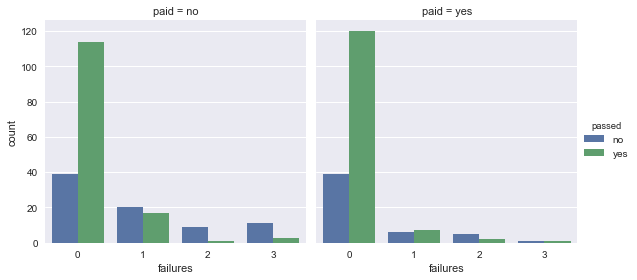

In [41]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

%matplotlib inline
import seaborn as sns
sns.factorplot("failures", col="paid", data=student_data, hue='passed', kind="count");

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [42]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [43]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = 95

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.24, random_state=10)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **Models:Decision Trees, SVM and k-Nearest Neighbors.

One real application for Decision Tree is personal assistant, so let's imagine that i want to record my daily routine, for examples when i want to sleep, when i like to take my breakfast or when i usually read my emails. This personal assistant can learn this supervised model, and predict when i do these tasks.

Strengths
- It's easily understandable.
- It can handle hard problems.
- You can make a conjunction with other Supervised Learning Techniques.
- Can handle numerical and nominal data
- It can handle dataset with blank data(unknown data)
- Don't require normalazing data

Weaknesses:
- It can easy overfit a model, that's why people usually prune their model.
- Since it's calculated the gain and entrophy for every feature, it might take a longe computacional time.
- Optimal decision tree techniques are NP-complete

Decision Tree(ID3) performs well on training dataset, however, when presented new data, it might perform below the expected.

Decision Tree is a good model for this particular problem because the student_interention data have nominal and numeric data, have many features and it can be a benchmark for others techniques.

References:
TOM MITCHELL, RICH CARUANA, DAYNE FREITAG, JOHN MCDERMOTT, AND DAVID ZABOWSKI. Experience with a learning personal assistant. Communications of the ACM, July 1994.
http://www.cs.ubbcluj.ro/~gabis/DocDiplome/DT/DecisionTrees.pdf
http://scikit-learn.org/0.17/modules/tree.html

For SVM, a real application would be facial expression classification, so let's imagine if we could classify if a coworker is doing ok by just running a model or he/she might be facing a hard time at home, this is awesome.

Strengths
- Work well on domains that can be separte with a straight line
- There is a regularisation parameter, which refine our model
- Can handle convex problems, which are based on global optima

Weaknesses:
- Don't perform so well on large dataset

SVM can handle non linear problems with kernel function(kernel trick), since most real class data are non linear, it's a suitable technique for this problem.

References:
J. Ghent and J. McDonald, "Facial Expression Classification using a One-Against-All Support Vector Machine", proceedings of the Irish Machine Vision and Image Processing Conference, Aug 2005.
https://core.ac.uk/download/pdf/6302770.pdf

KNN algorithm is often used to predict the price of stock market, so with that prediction we can play short position or long position.

Strengths
- Robust to noisy Training Data
- Low computacional time
- Effective in high dimesional spaces

Weakness
- Curse of Dimensionality (exponencial grow to generalization)
- SVMs do not directly provide probability estimates

KNN is robust to noise, which is also another caracteristic from a real application.

References:
http://people.revoledu.com/kardi/tutorial/KNN/Strength%20and%20Weakness.htm
http://www.cs.upc.edu/~bejar/apren/docum/trans/03d-algind-knn-eng.pdf
http://scikit-learn.org/0.17/modules/svm.html

**In general, with model selection it's often a good idea to try out simpler methods like Logistic Regression as a benchmark, and then move on to non-linear classifiers such as your choice of SVM, Decision Trees, and KNN.**

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [45]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [49]:
# TODO: Import the three supervised learning models from sklearn
# from sklearn import model_A
from sklearn.tree import DecisionTreeClassifier
# from sklearn import model_B
from sklearn.neighbors import KNeighborsClassifier
# from sklearn import model_C
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state=10)
clf_B = KNeighborsClassifier(n_neighbors=3,weights = 'uniform',algorithm='auto') #KNeighborsClassifier doesn't have random_state
clf_C = SVC(random_state=10)

# TODO: Set up the training set sizes
X_train_100 = X_train[0:100]
y_train_100 = y_train[0:100]

X_train_200 = X_train[0:200]
y_train_200 = y_train[0:200]

X_train_300 = X_train
y_train_300 = y_train

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
print "Decision Tree Classifier (100 Size)"
print train_predict(clf_A,X_train_100,y_train_100,X_test,y_test)
print "Decision KNN (100 Size)"
print train_predict(clf_B,X_train_100,y_train_100,X_test,y_test)
print "Decision SVC (100 Size)"
print train_predict(clf_C,X_train_100,y_train_100,X_test,y_test)
print "Decision Tree Classifier (200 Size)"
print train_predict(clf_A,X_train_200,y_train_200,X_test,y_test)
print "Decision KNN (200 Size)"
print train_predict(clf_B,X_train_200,y_train_200,X_test,y_test)
print "Decision SVC (200 Size)"
print train_predict(clf_C,X_train_200,y_train_200,X_test,y_test)
print "Decision Tree Classifier (300 Size)"
print train_predict(clf_A,X_train_300,y_train_300,X_test,y_test)
print "Decision KNN (300 Size)"
print train_predict(clf_B,X_train_300,y_train_300,X_test,y_test)
print "Decision SVC (300 Size)"
print train_predict(clf_C,X_train_300,y_train_300,X_test,y_test)

# Default Models:
clf_A = DecisionTreeClassifier()
clf_B = KNeighborsClassifier()
clf_C = SVC()

print "Decision Tree Classifier (300 Size) Default"
print train_predict(clf_A,X_train_300,y_train_300,X_test,y_test)
print "Decision KNN (300 Size) Default"
print train_predict(clf_B,X_train_300,y_train_300,X_test,y_test)
print "Decision SVC (300 Size) Default"
print train_predict(clf_C,X_train_300,y_train_300,X_test,y_test)

Decision Tree Classifier (100 Size)
Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0090 seconds
Made predictions in 0.0020 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0020 seconds.
F1 score for test set: 0.6870.
None
Decision KNN (100 Size)
Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0060 seconds
Made predictions in 0.0090 seconds.
F1 score for training set: 0.8369.
Made predictions in 0.0070 seconds.
F1 score for test set: 0.7324.
None
Decision SVC (100 Size)
Training a SVC using a training set size of 100. . .
Trained model in 0.0080 seconds
Made predictions in 0.0040 seconds.
F1 score for training set: 0.8366.
Made predictions in 0.0030 seconds.
F1 score for test set: 0.8228.
None
Decision Tree Classifier (200 Size)
Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0080 seconds
Made predictions in 0.0030 seconds.
F1 score for trainin

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - DecisionTreeClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0060          |         0.0020         |      1.0000      |     0.6870      |
| 200               |         0.0080          |         0.0010         |      1.0000      |     0.7059      |
| 300               |         0.0100          |         0.0010         |      1.0000      |     0.6720      |

** Classifer 2 - KNeighborsClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0060          |         0.0070         |      0.8369      |     0.7324      |
| 200               |         0.0060          |         0.0070         |      0.8441      |     0.7669      |
| 300               |         0.0060          |         0.0110         |      0.8815      |     0.7626      |

** Classifer 3 - SVC**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0070          |         0.0030         |      0.8366      |     0.8228      |
| 200               |         0.0120          |         0.0040         |      0.8552      |     0.7947      |
| 300               |         0.0210          |         0.0060         |      0.8615      |     0.8079      |

The default DecisionTreeClassifier and KNeighborsClassifier performs better than the [100,200,300] Algorithm Classifier

Decision Tree Classifier (300 Size) Default
F1 score for test set: 0.6822.

Decision SVC (300 Size) Default
F1 score for test set: 0.7714.

Decision SVC (300 Size) Default
F1 score for test set: 0.8079.

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: ** The most appropriate is SVC, because it hasn't overfit with the training data(F1 Score(train)<<1), it has a good F1  Score(test), at least is the closest to 1 between all classifiers and it is robust to data noise.

There is a downside, it's the slowest technique between the three available.

It has taken 0.210 seconds, 350% seconds more than KNeighborsClassifier and 210% seconds more than DecisionTreeClassifier

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **SVM, Support Vector Machine is good when we can make a visible spread between the data(straight line), the main ideia is to maximize the distance between the support vectors, which are the core data for this technique.
- The SVM takes data about previous students (age, gender, family, etc), and uses them to create a function that draws a boundary between the students who passed and those who didn't. The boundary should be drawn so as to maximize the margin,and the margin is the distance between the support vectors.With that in mind, we can draw an optimal hyperplane which successfully separate "good students" and "bad students".Often, though, it's not easy to draw a decision boundary in low dimensions, so the SVM separates the passing and failing students by 3D dimensions, that is know as the kernel trick.
- Using this function created with students we already know passed or not, the SVM can look at new students' data and predict if they are more likely to be a passed_student("good student") or a failed student("bad student").

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [54]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
# TODO: Create the parameters list you wish to tune
parameters = {'C': [.01, .1, 1, 10, 100],'gamma': [100, 10, 1, 0.1, 0.01, 0.001],}

# TODO: Initialize the classifier
clf = SVC(random_state=10) #Same random_state=10 from untuned model

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label = 'yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,parameters,scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))
print
from sklearn.metrics import classification_report
print classification_report(y_test, grid_obj.predict(X_test))

Made predictions in 0.0120 seconds.
Tuned model has a training F1 score of 0.8330.
Made predictions in 0.0050 seconds.
Tuned model has a testing F1 score of 0.8182.

             precision    recall  f1-score   support

         no       0.57      0.14      0.22        29
        yes       0.72      0.95      0.82        66

avg / total       0.67      0.71      0.64        95



### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** F1(final model) - Training: 0.8330, Testing: 0.8182

Untuned Mode F1(SVM) - Training: 0.8615, Training Time: 0.0160 seconds, Testing: 0.8079, Testing Time:0.0060 seconds

Untuned Model Data
- Made predictions in 0.0160 seconds.
- F1 score for training set: 0.8615.
- Made predictions in 0.0060 seconds.
- F1 score for test set: 0.8079.

Tuned Model Data
- Made predictions in 0.0120 seconds.
- Tuned model has a training F1 score of 0.8330.
- Made predictions in 0.0050 seconds.
- Tuned model has a testing F1 score of 0.8182.

The tuned model has a lower prediction time and a better F1 score, the tuned model works really well.

One thing that should be said, it's that the F1 score for training set in the Untuned Model has a better score(0.8615) than the Tuned Model(0.8330).
That's probably because the Tuned model could generalize better the data, and avoid 'overfitting' too much based on training data.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.